<a href="https://colab.research.google.com/github/oak2905/binary_prediction/blob/main/models_results_BinaryPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader.data as reader
import datetime as dt
import tensorflow as tf
import math
from keras.layers import LSTM, GRU, SimpleRNN
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import the data**


In [ ]:
# import required module
import os
# assign directory
directory = '/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF'
datasets = []
# iterate over files in
# that directory
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        print(f)
    df = pd.read_csv(f)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    df = df.dropna(axis = 0)
    df = df.astype('int64')
    datasets.append(df)
    

/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEBANK_05.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^BSESN_05.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEI_05.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^CNXIT_05.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEMDCP50_05.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEI_02.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEBANK_02.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEMDCP50_02.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^BSESN_02.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^CNXIT_02.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEI_10.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^NSEBANK_10.csv
/content/drive/MyDrive/Binary_Classification/Datasets_QW_BF/^BSESN_10.csv
/content/drive/MyDrive/Bina

In [ ]:
datasets[0]

,sma_trend,macd_trend,CCI_trend,RSI_trend,momentum_trend,stck_trend,stcd_trend,ado_trend,lwr_trend,price_trend
Date,,,,,,,,,,
2011-01-31,1,1,1,1,1,1,0,0,0,1
2011-02-01,1,0,0,0,1,0,0,1,1,0
2011-02-02,1,0,0,0,0,0,0,0,1,0
2011-02-03,1,1,1,1,1,1,1,0,0,1
2011-02-04,1,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0,1,0,0,1,0,0,1,1,0
2019-12-24,0,0,0,0,1,0,0,1,1,0
2019-12-26,0,0,0,0,1,0,0,1,1,0


In [ ]:
from sklearn.feature_selection import chi2
p_values_all = []
df = pd.DataFrame()
for i in range(len(datasets)):

  df = datasets[i]
  X = df.loc[:,df.columns != 'price_trend']
  X[X<0] = 0
  y = df['price_trend']
  chi_scores = chi2(X,y)

  p_values = pd.Series(chi_scores[1],index = X.columns)
  p_values.sort_values(ascending = False , inplace = True)
  p_values_all.append(p_values)
p_values_all[3]

momentum_trend    9.142137e-07
sma_trend         2.290614e-09
macd_trend        8.085826e-31
ado_trend         3.348540e-33
stcd_trend        1.650753e-34
CCI_trend         1.555961e-50
RSI_trend         1.110203e-60
lwr_trend         1.368918e-72
stck_trend        5.015996e-75
dtype: float64

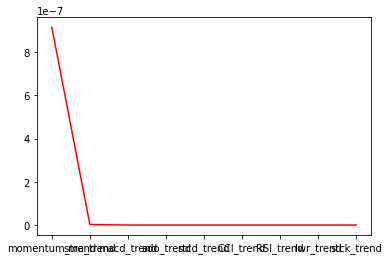

In [ ]:
plt.plot(p_values_all[3],color="red")
plt.show()

## **Creating the dataset**

In [ ]:
train_data_all = []
test_data_all = []
df = pd.DataFrame()
for i in range(len(datasets)):
 df = datasets[i]
 train_size = int(len(df)*0.8)
 train_data = df.iloc[:train_size]
 test_data = df.iloc[train_size:]
 train_data_all.append(train_data)
 test_data_all.append(test_data)

#X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)


GRU/LSTM/SimpleRNN accepts a 3D input of the format (num_samples, num_timesteps, num_features). In the following model lookback is 30 because it is assumed that the model makes predictions based on the past 30 days data. 

In [ ]:
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
 
    for i in range(len(X)-look_back):
        v = X[X.columns[0:6]].iloc[i:i+look_back]
        Xs.append(v)
        ys.append(X['price_trend'].iloc[i+look_back])
 
    return np.array(Xs), np.array(ys)
LOOK_BACK = 10
X_train_all = []
y_train_all = []
X_test_all = []
y_test_all = []
for i in range(len(datasets)):

  X_train, y_train = create_dataset(train_data_all[i],LOOK_BACK)
  X_test, y_test = create_dataset(test_data_all[i],LOOK_BACK)
  y_train = y_train.reshape(-1,1)
  y_test = y_test.reshape(-1,1)
  X_train_all.append(X_train)
  X_test_all.append(X_test)
  y_train_all.append(y_train)
  y_test_all.append(y_test)
# Print data shape
  print('\nX_train.shape: ', X_train.shape)
  print('y_train.shape: ', y_train.shape)
  print('X_test.shape: ', X_test.shape) 
  print('y_test.shape: ', y_test.shape)


X_train.shape:  (1514, 10, 6)
y_train.shape:  (1514, 1)
X_test.shape:  (371, 10, 6)
y_test.shape:  (371, 1)

X_train.shape:  (1735, 10, 6)
y_train.shape:  (1735, 1)
X_test.shape:  (427, 10, 6)
y_test.shape:  (427, 1)

X_train.shape:  (1728, 10, 6)
y_train.shape:  (1728, 1)
X_test.shape:  (425, 10, 6)
y_test.shape:  (425, 1)

X_train.shape:  (1502, 10, 6)
y_train.shape:  (1502, 1)
X_test.shape:  (368, 10, 6)
y_test.shape:  (368, 1)

X_train.shape:  (1713, 10, 6)
y_train.shape:  (1713, 1)
X_test.shape:  (421, 10, 6)
y_test.shape:  (421, 1)

X_train.shape:  (1728, 10, 6)
y_train.shape:  (1728, 1)
X_test.shape:  (425, 10, 6)
y_test.shape:  (425, 1)

X_train.shape:  (1514, 10, 6)
y_train.shape:  (1514, 1)
X_test.shape:  (371, 10, 6)
y_test.shape:  (371, 1)

X_train.shape:  (1713, 10, 6)
y_train.shape:  (1713, 1)
X_test.shape:  (421, 10, 6)
y_test.shape:  (421, 1)

X_train.shape:  (1735, 10, 6)
y_train.shape:  (1735, 1)
X_test.shape:  (427, 10, 6)
y_test.shape:  (427, 1)

X_train.shape:  (1

## **Creating and fitting the Model**

**(1) GRU**

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer
    model.add(GRU (units = units, return_sequences = True, 
                   input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 

    # Hidden layer
    model.add(GRU(units = 100)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 100))
    model.add(Dense(2, activation='softmax')) 
    #Compile model
    #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["binary_accuracy"])
    model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model
model_gru = create_gru(64)
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 10, 64)            13824     
                                                                 
 dropout (Dropout)           (None, 10, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 100)               49800     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense (Dense)               (None, 100)               10100     
                                                                 
 dense_1 (Dense)             (None, 2)                 202       
                                                                 
Total params: 73,926
Trainable params: 73,926
Non-traina

**(2) LSTM**

In [ ]:
# Create LSTM model
def create_lstm(units):
    model = Sequential()
    # Input layer
    model.add(LSTM (units = units, return_sequences = True, 
                   input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 

    # Hidden layer
    model.add(LSTM(units = 100)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 100))
    model.add(Dense(2, activation='softmax')) 
    #Compile model
    #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["binary_accuracy"])
    model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model
model_lstm = create_lstm(64)
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            18176     
                                                                 
 dropout_2 (Dropout)         (None, 10, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               66000     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 2)                 202       
                                                                 
Total params: 94,478
Trainable params: 94,478
Non-trai

**(3) RNN**

In [ ]:
# Create RNN model
def create_rnn(units):
    model = Sequential()
    # Input layer
    model.add(SimpleRNN (units, return_sequences = True, 
                        input_shape=[X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 

    # Hidden layer
    model.add(SimpleRNN(units = 100)) 
    model.add(Dropout(0.2))
    model.add(Dense(units = 100))
    model.add(Dense(2, activation='softmax')) 
    #Compile model
    #model.compile(optimizer='adam',loss='binary_crossentropy',metrics=["binary_accuracy"])
    model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    return model
model_rnn = create_rnn(64)
model_rnn.build(X_train.shape)
model_rnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 10, 64)            4544      
                                                                 
 dropout_4 (Dropout)         (None, 10, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 100)               16500     
                                                                 
 dropout_5 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 2)                 202       
                                                                 
Total params: 31,346
Trainable params: 31,346
Non-trai

In [ ]:
def fit_model(model,X_train,y_train):
    #early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
    callbacks = [
      keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=10, min_lr=0.00000000000000000001
      ),
      keras.callbacks.EarlyStopping(monitor="val_loss", patience=100, verbose=1),
    ]
    history = model.fit(X_train, y_train, epochs = 10000,  
                        validation_split = 0.2,
                        batch_size = 16, shuffle = False, 
                        callbacks = callbacks)
    return history

In [ ]:
#For GRU
models_gru = []
histories_gru = []
for i in range(len(datasets)):
  history_gru = fit_model(model_gru,X_train_all[i],y_train_all[i]) #Call back that records events into history object
  models_gru.append(model_gru)
  histories_gru.append(history_gru)


Epoch 1/10000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


76/76 [==============================] - 6s 28ms/step - loss: 0.6649 - accuracy: 0.6367 - val_loss: 0.5872 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 2/10000
76/76 [==============================] - 1s 17ms/step - loss: 0.6534 - accuracy: 0.6424 - val_loss: 0.5872 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 3/10000
76/76 [==============================] - 1s 16ms/step - loss: 0.6538 - accuracy: 0.6375 - val_loss: 0.5931 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 4/10000
76/76 [==============================] - 1s 16ms/step - loss: 0.6513 - accuracy: 0.6400 - val_loss: 0.5954 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 5/10000
76/76 [==============================] - 1s 16ms/step - loss: 0.6503 - accuracy: 0.6416 - val_loss: 0.5940 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 6/10000
76/76 [==============================] - 1s 16ms/step - loss: 0.6489 - accuracy: 0.6408 - val_loss: 0.5949 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 7/10000
76/76 [==============================] - 1s 16ms/step - lo

In [ ]:
#For LSTM
models_lstm = []
histories_lstm = []
for i in range(len(datasets)):
  history_lstm = fit_model(model_lstm,X_train_all[i],y_train_all[i]) #Call back that records events into history object
  models_lstm.append(model_lstm)
  histories_lstm.append(history_lstm)

Epoch 1/10000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


76/76 [==============================] - 6s 29ms/step - loss: 0.6595 - accuracy: 0.6433 - val_loss: 0.5876 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 2/10000
76/76 [==============================] - 1s 17ms/step - loss: 0.6545 - accuracy: 0.6433 - val_loss: 0.5902 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 3/10000
76/76 [==============================] - 1s 17ms/step - loss: 0.6538 - accuracy: 0.6433 - val_loss: 0.5963 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 4/10000
76/76 [==============================] - 1s 17ms/step - loss: 0.6511 - accuracy: 0.6433 - val_loss: 0.5958 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 5/10000
76/76 [==============================] - 1s 17ms/step - loss: 0.6505 - accuracy: 0.6433 - val_loss: 0.5938 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 6/10000
76/76 [==============================] - 1s 18ms/step - loss: 0.6504 - accuracy: 0.6457 - val_loss: 0.5978 - val_accuracy: 0.7294 - lr: 0.0010
Epoch 7/10000
76/76 [==============================] - 1s 17ms/step - lo

In [ ]:
#For RNN
models_rnn = []
histories_rnn = []
for i in range(len(datasets)):
  history_rnn = fit_model(model_rnn,X_train_all[i],y_train_all[i]) #Call back that records events into history object
  models_rnn.append(model_rnn)
  histories_rnn.append(history_rnn)

Epoch 1/10000


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


Streaming output truncated to the last 5000 lines.
Epoch 45/10000
87/87 [==============================] - 1s 8ms/step - loss: 1.0723 - accuracy: 0.6362 - val_loss: 1.1407 - val_accuracy: 0.5821 - lr: 9.7656e-07
Epoch 46/10000
87/87 [==============================] - 1s 9ms/step - loss: 1.0558 - accuracy: 0.6376 - val_loss: 1.1387 - val_accuracy: 0.5821 - lr: 9.7656e-07
Epoch 47/10000
87/87 [==============================] - 1s 9ms/step - loss: 1.0978 - accuracy: 0.6297 - val_loss: 1.1363 - val_accuracy: 0.5793 - lr: 9.7656e-07
Epoch 48/10000
87/87 [==============================] - 1s 9ms/step - loss: 1.0714 - accuracy: 0.6405 - val_loss: 1.1341 - val_accuracy: 0.5793 - lr: 9.7656e-07
Epoch 49/10000
87/87 [==============================] - 1s 8ms/step - loss: 1.0445 - accuracy: 0.6376 - val_loss: 1.1319 - val_accuracy: 0.5821 - lr: 9.7656e-07
Epoch 50/10000
87/87 [==============================] - 1s 9ms/step - loss: 1.0529 - accuracy: 0.6225 - val_loss: 1.1296 - val_accuracy: 0.5821 

## **Prediction**

In [ ]:
# Make prediction
def prediction(x_test, model):
    prediction = model.predict(x_test)
    prediction1 = []
    #sigmoid function is used in the last layer hence if output is greater than 0.5 then pred = 1 and vice versa
    #for i in range(len(prediction)):
     #if prediction[i]<0.5:
       #prediction[i]=1
     #else:
       #prediction[i]=0
    for i in range(len(prediction)):
       if prediction[i][0]>prediction[i][1]:
         prediction1.append(0)
       else:
         prediction1.append(1)

    return prediction1

# Plot test data vs prediction
def plot_conf_matrix(prediction, model_name, y_test):
    conf_matrix = confusion_matrix(y_true=y_test, y_pred=prediction)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix {model_name}'.format(model_name = model_name), fontsize=18)
    plt.show()  



## **Metrics**

In [ ]:
from sklearn.metrics import confusion_matrix


def compute_precision(y_test,pred):
	tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
	'''
	Precision = TP  / FP + TP 

	'''
	return (tp )/ float( tp + fp)
def compute_recall(y_test,pred):
	tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
	'''
	Recall = TP /FN + TP 

	'''
	return (tp  )/ float( tp + fn)
def compute_f1_score(y_test, pred):
    # calculates the F1 score
    precision = compute_precision(y_test, pred)
    recall = compute_recall(y_test, pred)
    f1_score = (2*precision*recall)/ (precision + recall)
    return f1_score

def compute_accuracy(y_test, pred):
		tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel()
		return (tp+tn)/float(tp+tn+fp+fn)


In [ ]:
fname = []
for filename in os.listdir(directory):
    fname.append(filename[1:-4])

### **Precision**

In [ ]:
#for GRU
precision = 0
precision_scores_array_gru = []
prediction_gru_all = [0]*len(datasets)
for i in range(len(datasets)):
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  prediction_gru_all[i] = prediction(X_test_all[i],model_gru)
  precision = compute_precision(y_test_all[i], prediction_gru_all[i])
  precision_scores_array_gru.append(precision)

In [ ]:
#for LSTM
precision = 0
precision_scores_array_lstm = []
prediction_lstm_all = [0]*len(datasets)
for i in range(len(datasets)):
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  prediction_lstm_all[i] = prediction(X_test_all[i],model_lstm)
  precision = compute_precision(y_test_all[i], prediction_lstm_all[i])
  precision_scores_array_lstm.append(precision)

In [ ]:
#for RNN
precision = 0
precision_scores_array_rnn = []
prediction_rnn_all = [0]*len(datasets)
for i in range(len(datasets)):
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  prediction_rnn_all[i] = prediction(X_test_all[i],model_rnn)
  precision = compute_precision(y_test_all[i], prediction_rnn_all[i])
  precision_scores_array_rnn.append(precision)

In [ ]:
data = {'Index': fname, 'GRU': precision_scores_array_gru,'LSTM': precision_scores_array_lstm,'RNN': precision_scores_array_rnn}
precision_scores_df = pd.DataFrame()
precision_scores_df = pd.DataFrame(data)
precision_scores_df

,Index,GRU,LSTM,RNN
0,NSEBANK_05,0.500000,0.437500,0.450000
1,BSESN_05,0.500000,0.250000,0.321429
2,NSEI_05,0.333333,0.454545,0.275862
3,CNXIT_05,0.000000,0.250000,0.314815
4,NSEMDCP50_05,0.526316,0.407407,0.268657
5,NSEI_02,0.500000,0.454545,0.431034
6,NSEBANK_02,0.500000,0.500000,0.575000
7,NSEMDCP50_02,0.578947,0.481481,0.358209
8,BSESN_02,0.750000,0.250000,0.535714
9,CNXIT_02,0.666667,0.500000,0.462963


### **Recall**

In [ ]:
#for GRU
recall = 0
recall_scores_array_gru = []
prediction_gru_all = [0]*len(datasets)
for i in range(len(datasets)):
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  prediction_gru_all[i] = prediction(X_test_all[i],model_gru)
  recall = compute_recall(y_test_all[i], prediction_gru_all[i])
  recall_scores_array_gru.append(recall)

In [ ]:
#for LSTM
recall = 0
recall_scores_array_lstm = []
prediction_lstm_all = [0]*len(datasets)
for i in range(len(datasets)):
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  prediction_lstm_all[i] = prediction(X_test_all[i],model_lstm)
  recall = compute_recall(y_test_all[i], prediction_lstm_all[i])
  recall_scores_array_lstm.append(recall)

In [ ]:
#for RNN
recall = 0
recall_scores_array_rnn = []
prediction_rnn_all = [0]*len(datasets)
for i in range(len(datasets)):
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  prediction_rnn_all[i] = prediction(X_test_all[i],model_rnn)
  recall = compute_recall(y_test_all[i], prediction_rnn_all[i])
  recall_scores_array_rnn.append(recall)

In [ ]:
data = {'Index': fname, 'GRU': recall_scores_array_gru,'LSTM': recall_scores_array_lstm,'RNN': recall_scores_array_rnn}
recall_scores_df = pd.DataFrame()
recall_scores_df = pd.DataFrame(data)
recall_scores_df

,Index,GRU,LSTM,RNN
0,NSEBANK_05,0.048000,0.056000,0.144000
1,BSESN_05,0.017094,0.008547,0.153846
2,NSEI_05,0.017241,0.043103,0.137931
3,CNXIT_05,0.000000,0.008197,0.139344
4,NSEMDCP50_05,0.070922,0.078014,0.127660
5,NSEI_02,0.016575,0.027624,0.138122
6,NSEBANK_02,0.036585,0.048780,0.140244
7,NSEMDCP50_02,0.058511,0.069149,0.127660
8,BSESN_02,0.016129,0.005376,0.161290
9,CNXIT_02,0.012121,0.012121,0.151515


### **Accuracy**

In [ ]:
#for GRU
accuracy_all_gru = []
prediction_gru_all = [0]*len(datasets)
acc = 0
for i in range(len(datasets)):
  prediction_gru_all[i] = prediction(X_test_all[i],model_gru)
  acc = compute_accuracy(y_test_all[i],prediction_gru_all[i])
  accuracy_all_gru.append(acc)

In [ ]:
#for LSTM
accuracy_all_lstm = []
acc = 0
for i in range(len(datasets)):
  acc = compute_accuracy(y_test_all[i],prediction_lstm_all[i])
  accuracy_all_lstm.append(acc)

In [ ]:
#for RNN
accuracy_all_rnn = []
acc = 0
for i in range(len(datasets)):
  acc = compute_accuracy(y_test_all[i],prediction_rnn_all[i])
  accuracy_all_rnn.append(acc)

In [ ]:
data = {'Index': fname, 'GRU': accuracy_all_gru ,'LSTM': accuracy_all_lstm,'RNN': accuracy_all_rnn}
accuracy_scores_df = pd.DataFrame()
accuracy_scores_df = pd.DataFrame(data)
accuracy_scores_df

,Index,GRU,LSTM,RNN
0,NSEBANK_05,0.663073,0.657682,0.652291
1,BSESN_05,0.725995,0.721311,0.679157
2,NSEI_05,0.722353,0.724706,0.665882
3,CNXIT_05,0.660326,0.663043,0.614130
4,NSEMDCP50_05,0.667458,0.653207,0.591449
5,NSEI_02,0.574118,0.571765,0.555294
6,NSEBANK_02,0.557951,0.557951,0.574124
7,NSEMDCP50_02,0.560570,0.551069,0.508314
8,BSESN_02,0.569087,0.559719,0.573770
9,CNXIT_02,0.554348,0.551630,0.540761


### **F1-Scores**

In [ ]:
#for GRU
prediction_gru_all = [0]*len(datasets)
f1 = 0
f1_scores_array_gru = []
for i in range(len(datasets)):
  prediction_gru_all[i] = prediction(X_test_all[i],model_gru)
  #plot_conf_matrix(prediction_gru_all[i], 'GRU', y_test_all[i])
  f1 = compute_f1_score(y_test_all[i], prediction_gru_all[i])
  f1_scores_array_gru.append(f1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
#for LSTM
prediction_lstm_all = [0]*len(datasets)
f1 = 0
f1_scores_array_lstm = []
for i in range(len(datasets)):
  prediction_lstm_all[i] = prediction(X_test_all[i],models_lstm[i])
  #plot_conf_matrix(prediction_lstm_all[i], 'LSTM', y_test_all[i])
  f1 = compute_f1_score(y_test_all[i], prediction_lstm_all[i])
  f1_scores_array_lstm.append(f1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
#for RNN
prediction_rnn_all = [0]*len(datasets)
f1 = 0
f1_scores_array_rnn = []
for i in range(len(datasets)):
  prediction_rnn_all[i] = prediction(X_test_all[i],models_rnn[i])
  #plot_conf_matrix(prediction_lstm_all[i], 'LSTM', y_test_all[i])
  f1 = compute_f1_score(y_test_all[i], prediction_rnn_all[i])
  f1_scores_array_rnn.append(f1)

In [ ]:
data = {'Index': fname, 'GRU': f1_scores_array_gru,'LSTM': f1_scores_array_lstm,'RNN': f1_scores_array_rnn}
f1_scores_df = pd.DataFrame()
f1_scores_df = pd.DataFrame(data)
f1_scores_df

,Index,GRU,LSTM,RNN
0,NSEBANK_05,0.087591,0.099291,0.218182
1,BSESN_05,0.033058,0.016529,0.208092
2,NSEI_05,0.032787,0.078740,0.183908
3,CNXIT_05,NaN,0.015873,0.193182
4,NSEMDCP50_05,0.125000,0.130952,0.173077
5,NSEI_02,0.032086,0.052083,0.209205
6,NSEBANK_02,0.068182,0.088889,0.225490
7,NSEMDCP50_02,0.106280,0.120930,0.188235
8,BSESN_02,0.031579,0.010526,0.247934
9,CNXIT_02,0.023810,0.023669,0.228311


In [ ]:
if(os.path.isfile('/content/drive/MyDrive/binary_prediction/Metrics/metrics.xlsx')==True):
  os.remove('/content/drive/MyDrive/binary_prediction/Metrics/metrics.xlsx')
with pd.ExcelWriter('/content/drive/MyDrive/binary_prediction/Metrics/metrics.xlsx') as writer:  
    f1_scores_df.to_excel(writer, sheet_name='F1-score')
    accuracy_scores_df.to_excel(writer, sheet_name='accuracy')
    precision_scores_df.to_excel(writer, sheet_name='precision')
    recall_scores_df.to_excel(writer, sheet_name='recall')